# MATH6380O mini-project 1

Author: Chunyan BAI, Haoye CAI, Yuan CHEN, Wenshuo GUO

2018.2.26

### Distribution of work

- Chunyan BAI: Feature extraction by scattering net with known invariants;
- Wenshuo GUO: Feature extraction by pre-trained deep neural networks, e.g. VGG19, and resnet50;
- Yuan CHEN: Visualize these features using classical unsupervised learning methods, e.g. PCA, t-SNE, MDS, LLE, isomap, Spectral Embedding (SE);
- Haoye CAI: Image classifications using traditional supervised learning methods based on the features
extracted, e.g. LDA, logistic regression, SVM, random forests;
- All members equally: Report writing. Compare the results obtained and give analysis on explaining the phenomena.

### Introduction
In this project, we utilize the idea of transfer learning to extract features from two datasets and perform classification task - Raphel's dataset and MNIST's dataset, using pre-trained deep nerual networks and scattering nets. We also use various visualization approaches, such as PCA, MDS and t-SNE etc. to visualize the extracted features so that we could better understand how these networks perform and their ability in feature extraction and preservation from the visual intuition. Furthermore, we implemenet multiple traditional supervised learning methods based on the extracted features, including LDA, logistic regression, SVM, random forests to classify images. We will present the experiment results and give in-depth analysis on why such results are formed, and what they reveal about the feature extraction framework.

### Related Work
1. Scattering Network

  We hereby adopt the improved version of scattering network as proposed by Oyallon et al [1]. This invariant scattering network utilized two wavelet transformation to build a non-trivial invariant and retain both high-frequency and low-frequency domain. To deal with images, we apply scattering transformation on each RGB channel of the image, resulting in a final channel of $3\times(1+JL+\dfrac{1}{2}J(J-1)L^2)$, and the image is downsampled by a factor of $2^J$, where $J$ is the spatial scale of scattering transform and $L$ is an integer parametrizing a discretization of $[0, 2\pi]$. We use scattering network to explore its efficiency compared with modern data-driven neural networks.
 
2. VGG19 and ResNet50

  Both VGG [3] and ResNet [4] are convolutional neural networks designed to perform image recongnition. Their success on ImageNet [5] dataset has proven their efficacy in extracting meaningful feature from general images. Therefore we choose VGG19 and ResNet50 pre-trained on ImageNet as the base neural network for feature extraction in this project. These two networks also make good comparision against each other since VGG19 is considered shallow but may preserve more details in its feature map, while ResNet50 is much deeper and the final feature consists of high-level visual cues.
  
3. MNIST

  MNIST is a simple yet effective dataset to explore the learnt feature of networks, given it is made up of numerous hand-written digits. It consists of 60000 gray-scale training images of size 28*28 and 10 classes. In our experiment we resize all the images to 224*224, and choose only a subset of the train/test images due to time concern.
  
4. Identification of Raphael’s paintings from the forgeries
  
  Another dataset used is a small dataset of Raphael's/forgeries paintings, consisting of 28 images in total. The idea of whether extracted feature works on such a small dataset would further illustrates the difference/connection of various methodologies. There has been previous study on authenticating Van Gogh paintings by Liu et al [2]. Here we resize all the images to 224*224, and use transfer learning to train classifiers to identify forgeries. We use leave-one-out validation as the dataset is of limited size.
  

In [2]:
import numpy as np
import os
import time
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
import h5py 
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from keras.datasets import mnist
from skimage.transform import resize
from scatNet import scatNet
# from imagenet_utils import decode_predictions
# from keras.layers import Dense, Activation, Flatten
# from keras.layers import merge, Input
#import cv2
import visualizer
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from pandas.plotting import parallel_coordinates
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

# Dataset 1: Raphael’s paintings

Load the dataset.

In [4]:
# Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data2'
data_dir_list = os.listdir(data_path)
# data_dir_list.remove('.DS_Store')

In [5]:
data_dir_list.remove('.ipynb_checkpoints')

In [6]:
img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    if '.ipynb_checkpoints' in img_list:
        img_list.remove('.ipynb_checkpoints')
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    count = 0
    for img in img_list:
        count = count + 1
        img_path = data_path + '/'+ dataset + '/'+ img
#         if 'tif' not in img:
#             img = image.load_img(img_path, target_size=(224, 224))
#         else:
#             tif = TIFF.open(img_path, mode='r')
#             img = tif.read_image()
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_data_list.append(x)
    print('Number images of dataset-'+'{}\n'.format(dataset)),count
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
img_data=np.rollaxis(img_data,1,0)
img_data=img_data[0]

Loaded the images of dataset-raphael

Number images of dataset-raphael
12
Loaded the images of dataset-notRaphael

Number images of dataset-notRaphael
10


In [7]:
# Load the test set
test_img_data_list = []
test_img_name_list = []
for img_path in os.listdir('test'):
    img = image.load_img(os.path.join('test', img_path), target_size=(224, 224))
    test_img_name_list.append(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    test_img_data_list.append(x)
print('Number images of test set - '+'{}\n'.format(len(test_img_data_list)))
test_img_data = np.array(test_img_data_list)
test_img_data=np.squeeze(test_img_data)
print test_img_name_list

Number images of test set - 6

['25. 156x115.tif', '7. 243x413 .tiff', '23. 84x68.tif', '10. 269x227.TIF', '1. 185x354.TIF', '26. 197x187.tif']


Define the util function for feature visualization. We use six visualization methods for this part to compare from different perspectives: PCA, t-SNE, MDS, LLE, isomap, Spectral Embedding (SE).

In [8]:
def visualize_raphael(feature):
    projected_feature = visualizer.vis_pca(feature)

    fig = plt.figure(figsize=(15, 10))
    plt.prism()

    plot = fig.add_subplot(2,3,1)
    plot.set_title("PCA")
    for i in range(projected_feature.shape[0]):
        if i < 12:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#1f78b4")
        else:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#e31a1c")

    projected_feature = visualizer.vis_tsne(feature)
    plot = fig.add_subplot(2,3,2)
    plot.set_title("TSNE")
    for i in range(projected_feature.shape[0]):
        if i < 12:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#1f78b4")
        else:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#e31a1c")

    projected_feature = visualizer.vis_mds(feature)
    plot = fig.add_subplot(2,3,3)
    plot.set_title("MDS")
    for i in range(projected_feature.shape[0]):
        if i < 12:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#1f78b4")
        else:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#e31a1c")

    projected_feature = visualizer.vis_lle(feature)
    plot = fig.add_subplot(2,3,4)
    plot.set_title("LLE")
    for i in range(projected_feature.shape[0]):
        if i < 12:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#1f78b4")
        else:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#e31a1c")

    projected_feature = visualizer.vis_isomap(feature)
    plot = fig.add_subplot(2,3,5)
    plot.set_title("ISOMAP")
    for i in range(projected_feature.shape[0]):
        if i < 12:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#1f78b4")
        else:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#e31a1c")

    projected_feature = visualizer.vis_se(feature)
    plot = fig.add_subplot(2,3,6)
    plot.set_title("SE")
    for i in range(projected_feature.shape[0]):
        if i < 12:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#1f78b4")
        else:
            plot.scatter(projected_feature[i][0], projected_feature[i][1], c = "#e31a1c")

    plt.show()

Define the util function for applying different classification methods to the extracted features. Specifically, we run four classification algorithms: SVM, LDA, Random Forest, and Logistic Regression, and test their accuracy using leave-one-out-cross-validation upon two common metrics, i.e. each time we select one sample among the 22 drawings as the test data and use the rest 21 drawings as the training data, then evaluate both cross entropy (equivalent to negative log likelihood) and accuracy on the test drawing, and finally calculate average statistics for the 22 results. 

In [9]:
def classification_raphael(features):
    # Apply different classification methods to the extracted features. Use LOOCV to evaluate the classification accuracy.
    # Evaluate BCE(log likelihood) and accuracy.

    num_img = features.shape[0]
    features = np.reshape(features, (num_img, -1))
    labels = [1] * 12 + [0] * 10  # 1 for being true, 0 for being false
    estimators = [SVC(probability=True),
                 LinearDiscriminantAnalysis(),
                 RandomForestClassifier(n_estimators=50),
                 LogisticRegression()]

    for estimator in estimators:
        bce_avg = []
        acc_avg = []
        for i in range(num_img):
            # leave this one out
            test_x = features[i:i+1, :]
            test_y = labels[i]
            test_p = float(test_y) # p being prob of real 

            # get training set
            train_x = np.delete(features, i, 0)
            train_y = [item for idx, item in enumerate(labels) if idx != i ]

            estimator.fit(train_x, train_y)
            y_hat = estimator.predict(test_x)
            p_hat = estimator.predict_proba(test_x)
            # print y_hat, p_hat

            # compare y_hat and test_y
            bce_err = log_loss([test_y], p_hat, labels=[0,1])
            acc_err = accuracy_score([test_y], y_hat)

            bce_avg.append(bce_err)
            acc_avg.append(acc_err)

        # average
        print ('{}: bce: {} | {}, acc: {} | {}'.format(type(estimator).__name__, np.mean(bce_avg), np.std(bce_avg), np.mean(acc_avg), np.std(acc_avg)))

## Scattering Network


Build a Scattering Network and conduct inference to get the features.

In [10]:
scat = scatNet(size=(224,224),layer=4)
scat_feature = scat.inference(img_data)

### Visulization of Scattering Network

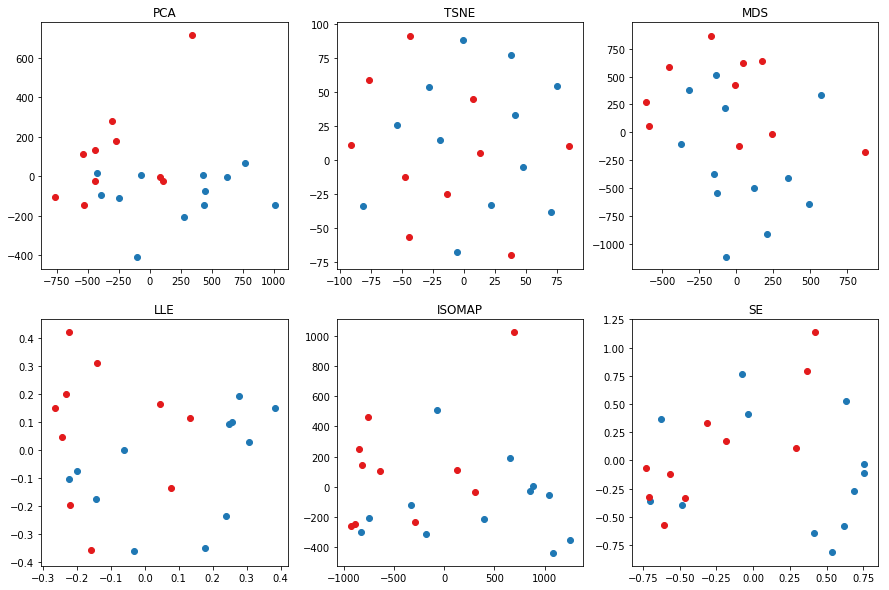

In [9]:
visualize_raphael(scat_feature)


From the figure above, we could find that the extracted features from the scattering network seem to separate into two parts - "Non-Raphale" and "Raphael". The scattering network seems to perform well in this dataset.

### Classification on the extracted features

Call our classification evaluation function. Outputs are cross entropy (negative log likelihood) and accuracy. The number before and after the '|' is the mean and the standard deviation respectively.

In [9]:
classification_raphael(scat_feature)

SVC: bce: 0.606957081328 | 0.329827523921, acc: 0.590909090909 | 0.491666083018
LinearDiscriminantAnalysis: bce: 6.67414304328 | 13.1406707877, acc: 0.590909090909 | 0.491666083018
RandomForestClassifier: bce: 0.647441553212 | 0.322877862044, acc: 0.681818181818 | 0.465770489362
LogisticRegression: bce: 0.333787774529 | 0.752503497757, acc: 0.863636363636 | 0.343174292512


As we can see from the statistics, for the features extracted by the Scattering Network, Logistic Regression has the lowest cross entropy loss and the highest accuracy, which indicates the best classification performance. When taking standard deviation into consideration, however, since all the standard deviations are relatively large, especially compared to the means, we find that all methods are actually similar (at least similarly unstable). This is understandable because as we can see in the visualizations, the extracted features cannot be easily linearly separated, and positive and negative features tend to mix together.

## VGG19

Build a VGG19 and extract the last layer.

In [11]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [12]:
model = VGG19(weights='imagenet', include_top=False)

In [13]:
vgg19_feature = model.predict(img_data)

### Visulization analysis of VGG19 Network

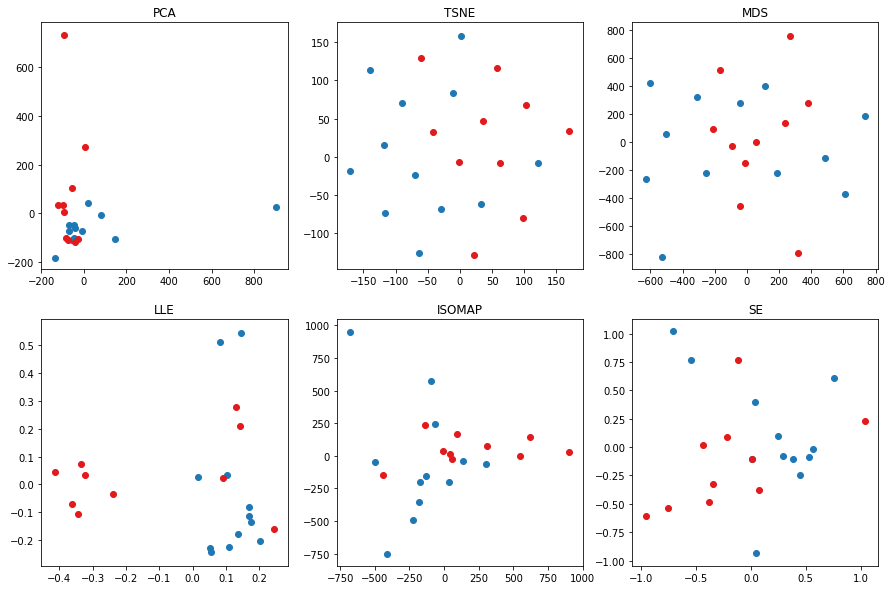

In [11]:
visualize_raphael(vgg19_feature)


PCA seems to project most extracted features in a relative small space after dimensional reduction. One of the reasons may  be the PCA miss some non-linear structure from the extracted feature date from the VGG19 model since other manifold learning approaches and t-SNE all perform well.

### Classification on the extracted features

Call our classification evaluation function. Outputs are cross entropy (negative log likelihood) and accuracy. The number before and after the '|' is the mean and the standard deviation respectively.

In [13]:
classification_raphael(vgg19_feature)

SVC: bce: 0.732629443491 | 0.0830013836569, acc: 0.545454545455 | 0.497929597732
LinearDiscriminantAnalysis: bce: 0.920833405594 | 0.433443803941, acc: 0.363636363636 | 0.481045692921
RandomForestClassifier: bce: 0.706377798049 | 0.224337240833, acc: 0.5 | 0.5
LogisticRegression: bce: 1.06694353663 | 1.59343385384, acc: 0.681818181818 | 0.465770489362


In [19]:
# Clear GPU memory
import gc
del model
gc.collect()
K.clear_session()

As we can see from the statistics, for the features extracted by the VGG19 Network, Logistic Regression still has the highest accuracy but Random Forest and SVM show the lowest cross entropy loss. Therefore we conclude for these features, the three classifiers mentioned indicate reasonably good performance. The bad performance shown by LDA may indicate this feature distribution violates the LDA gaussian assumtions.

## ResNet50
Build a ResNet50 and extract the last layer features.

In [14]:
model2 = ResNet50(weights='imagenet', include_top=False)

In [15]:
ResNet50_feature = model2.predict(img_data)

### Visulization analysis of ResNet50 Network

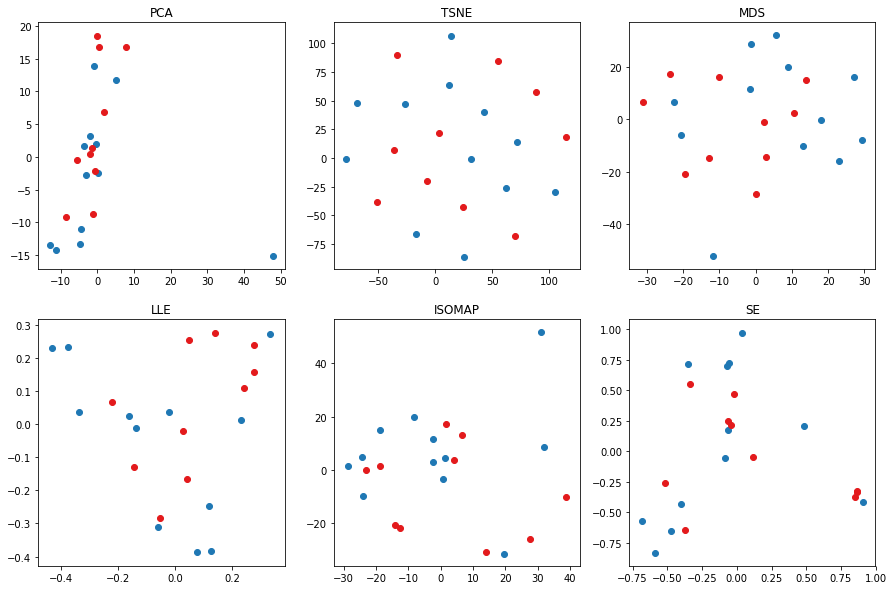

In [18]:
visualize_raphael(ResNet50_feature)


PCA seems to project most extracted features in the projection space linearly and other manifold learning approaches visualise features similar to those in VGG19, but we could still see that from spectral embedding that, ResNet50 seems to perform better in extracting non-linear structure in the data.

### Classification on the extracted features

Call our classification evaluation function. Outputs are cross entropy (negative log likelihood) and accuracy. The number before and after the '|' is the mean and the standard deviation respectively.

In [21]:
classification_raphael(ResNet50_feature)

SVC: bce: 0.848902438299 | 0.199775666422, acc: 0.545454545455 | 0.497929597732
LinearDiscriminantAnalysis: bce: 1.75302978976 | 4.2157984159, acc: 0.5 | 0.5
RandomForestClassifier: bce: 0.664865473447 | 0.235994520728, acc: 0.590909090909 | 0.491666083018
LogisticRegression: bce: 0.723769099988 | 0.81084204489, acc: 0.636363636364 | 0.481045692921


In [21]:
del model2
gc.collect()
K.clear_session()

As we can see from the statistics, for the features extracted by the ResNet50 Network, Logistic Regression still has the highest accuracy but the difference seems to further shrink, i.e. four methods have similar accuracy and cross entropy (except for LDA which has larger cross entropy). The bad/unstable output distribution shown by LDA may indicate this feature distribution violates the LDA gaussian assumtions. But more importantly, as shown in the visualization, the features from different classes seem to further mix together, making classifiers more difficult to distinguish. This may explain the not-so-good results shown by all methods.

## Visualization Summary - Raphael
For the Raphael's dataset, we used three networks to train and predict the extracted features and six approaches to visualise the extracted features. We want to analyse the visualisation via two aspects.

1. Deep Learning Networks Comparison through the Same Visualisation

    Using PCA to reduce the dimensions, we could see that the scattering network tends to separate the features into two parts. VGG19 tends to project most features in a relative small space while the ResNet50 tends to project most features linearly. From the visualizations, we could understand that these three networks perform differently in feature extraction, which may due to their different architectures. 

2. Different Visualisation Approaches through the Same Network

    We could see that different visualisation methods fit in different models. PCA is a linear transformation of the dimensions, and often miss important non-linear structure in the data. ISOMAP seeks a lower dimensional embedding which maintains geodesic distances between all points while Local linear Embedding seeks a lower-dimensional projection of the data which preserves distances within local neighbourhoods. That's way there exist obvious clusters in those two figures. Spectral Embedding performs better in non-linear structure embedding. After all, t-SNE seems to have the best performance among all six methods. The clusters are obvious than those in other figures and the points are projected almost uniformly in the space.

One limitation of this experiment is that the datasets is so small that after sampling, the number of features to be visualised is limited and it is hard to get more valuable insights from the visualisation.


## Classification Summary - Raphael
We summarize the classification results in the following table: (CE stands for cross entropy and Acc stands for accuracy)

|  | SVM   |  LDA  |  RandomForest  |  Logistic Regression |
|----------------|-----------------|---------------|----------------|------------|
| ScatNet (CE)  | 0.61 $\pm$ 0.33 | 6.67 $\pm$ 13.14 | 0.65 $\pm$ 0.32  | 0.33 $\pm$ 0.75 |
| ScatNet (Acc)  | 0.59 $\pm$ 0.49 | 0.59 $\pm$ 0.49 | 0.68 $\pm$ 0.47 | 0.86 $\pm$ 0.34 |
| VGG19 (CE)    | 0.73 $\pm$ 0.08 | 0.92 $\pm$ 0.43 | 0.71 $\pm$ 0.22 | 1.07 $\pm$ 1.59 |
| VGG19 (Acc)   | 0.55 $\pm$ 0.50 | 0.36 $\pm$ 0.48 | 0.50 $\pm$ 0.50 | 0.68 $\pm$ 0.47 |
| ResNet50 (CE)  | 0.85 $\pm$ 0.20 | 1.75 $\pm$ 4.20 | 0.66 $\pm$ 0.24 | 0.72 $\pm$ 0.81 |
| ResNet50 (Acc) | 0.55 $\pm$ 0.50 | 0.50 $\pm$ 0.50 | 0.59 $\pm$ 0.49 | 0.63 $\pm$ 0.48 |

By comparing the statistics, we first find that Logistic Regression achieve best accuracy/log loss for all types of features, and LDA almost always perform the worst. The first implication of this observation is that, this Raphael Drawing dataset has a data distribution that is very different from the LDA gaussion assumption. This may serve as the main reason for the bad performance. The next important observation is that, the simplest method seems to be more suitable for this dataset. Remember this is a small dataset containing only 22 pictures. This means more complicated methods like SVM have high potential to overfit, and simpler methods have better chance to make good decisions in the test set.

Another major comparison we make is which features are more robust, or more suitable for this dataset. As shown by the numbers, no matter for the best or the average performance by the classifiers, Scattering Network seems to provide more reasonable features. This may be explained by the ability inherent in the wavelet operations to process/find fixed patterns, which may enforce its analysis on the textures of drawings, thus leading to easier thresholds between classes. For the two deep nets, since they are trained on large scale datasets, they are more likely to find universal patterns which may not be helpful for this specific task. In addition, since ResNet50 has much more layers than VGG19 (increased depth), it may provide much more complicated and high-level features in deeper layers. This may be the reason why ResNet features seem to be more mixed.


## Results on the test set
From the table above, we chose to use features extracted by the Scattering Network and Logistic Regression to perform prediction on the test set. Since the ground truth labels are unknown, we just present the results here.

In [14]:
features = scat_feature
num_img = features.shape[0]
features = np.reshape(features, (num_img, -1))
labels = [1] * 12 + [0] * 10  # 1 for being true, 0 for being false
estimator = LogisticRegression()

estimator.fit(features, labels)


test_feature = scat.inference(test_img_data)
# print test_feature.shape

test_feature = np.reshape(test_feature, (test_feature.shape[0], -1))

pred = estimator.predict(test_feature)

for i in range(test_feature.shape[0]):
    print '{:20} {:10}'.format(test_img_name_list[i], 'Real' if pred[i] == 1 else 'Fake')

25. 156x115.tif      Real      
7. 243x413 .tiff     Fake      
23. 84x68.tif        Fake      
10. 269x227.TIF      Real      
1. 185x354.TIF       Real      
26. 197x187.tif      Fake      


# Dataset 2: MNIST

We further conduct our analysis on the MNIST dataset, which is a classical digit-recognition dataset commonly used for various types of algorithm analysis. Some key chracteristics include: data patterns are simple and easy to clustter, and the data size is significantly larger than the Raphael dataset.

In [16]:
#Load the MNIST dataset, flatten the images, convert the class labels, and scale the data.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print X_train.shape, X_test.shape
#rescale
x_train_list=[]
num = 0
y_train = []
for digit in X_train[:500]:
    num = num + 1
    y_train.append(Y_train[num -1])
    if num %5000 == 0:
        print num
    res = resize(digit, (224,224))
    res = preprocess_input(res)
    x_train_list.append(res)
x_train = np.array(x_train_list)
#artifically convert to rgb
x_train = np.stack((x_train,)*3, -1)

x_test_list=[]
num = 0
y_test = []
for digit in X_test[:50]:
    num = num + 1
    y_test.append(Y_test[num -1])
    if num %5000 == 0:
        print num
    res = resize(digit, (224,224))
    res = preprocess_input(res)
    x_test_list.append(res)
x_test = np.array(x_test_list)
#artifically convert to rgb
x_test = np.stack((x_test,)*3, -1)

(60000, 28, 28) (10000, 28, 28)


In [5]:
def visualize_mnist(feature):
    colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a"]
    projected_feature = visualizer.vis_pca(feature)

    fig = plt.figure(figsize=(15, 10))
    plt.prism()
    plot = fig.add_subplot(2,3,1)
    plot.set_title("PCA")
    for i in range(projected_feature.shape[0]):
        plot.scatter(projected_feature[i][0], projected_feature[i][1], c = colors[y_train[i]])

    projected_feature = visualizer.vis_tsne(feature)
    plot = fig.add_subplot(2,3,2)
    plot.set_title("TSNE")
    for i in range(projected_feature.shape[0]):
        plot.scatter(projected_feature[i][0], projected_feature[i][1], c = colors[y_train[i]])

    projected_feature = visualizer.vis_mds(feature)
    plot = fig.add_subplot(2,3,3)
    plot.set_title("MDS")
    for i in range(projected_feature.shape[0]):
        plot.scatter(projected_feature[i][0], projected_feature[i][1], c = colors[y_train[i]])

    projected_feature = visualizer.vis_lle(feature)
    plot = fig.add_subplot(2,3,4)
    plot.set_title("LLE")
    for i in range(projected_feature.shape[0]):
        plot.scatter(projected_feature[i][0], projected_feature[i][1], c = colors[y_train[i]])

    projected_feature = visualizer.vis_isomap(feature)
    plot = fig.add_subplot(2,3,5)
    plot.set_title("ISOMAP")
    for i in range(projected_feature.shape[0]):
        plot.scatter(projected_feature[i][0], projected_feature[i][1], c = colors[y_train[i]])

    projected_feature = visualizer.vis_se(feature)
    plot = fig.add_subplot(2,3,6)
    plot.set_title("SE")
    for i in range(projected_feature.shape[0]):
        plot.scatter(projected_feature[i][0], projected_feature[i][1], c = colors[y_train[i]])

    plt.show()

Define the util function for applying different classification methods to the extracted features. Specifically, we train four classification algorithms: SVM, LDA, Random Forest, and Logistic Regression on the MNIST training set, and test their cross entropy and accuracy on the test set.

In [6]:
def classification_mnist(train_features, train_labels, test_features, test_labels):
    # Apply different classification methods to the extracted features. 
    # Evaluate BCE(log likelihood) and accuracy.

    train_features = np.reshape(train_features, (train_features.shape[0], -1))
    test_features = np.reshape(test_features, (test_features.shape[0], -1))
    estimators = [SVC(probability=True),
                 LinearDiscriminantAnalysis(),
                 RandomForestClassifier(n_estimators=50),
                 LogisticRegression()]

    for estimator in estimators:

        estimator.fit(train_features, train_labels)
        y_hat = estimator.predict(test_features)
        p_hat = estimator.predict_proba(test_features)
        # print y_hat, p_hat

        # compare y_hat and test_y
        test_labels_set = np.array_split(test_labels, 10)
        p_hat_set = np.array_split(p_hat, 10)
        y_hat_set = np.array_split(y_hat, 10)
        # print test_labels_set.shape, p_hat_set.shape, y_hat_set.shape
        bce_avg = []
        acc_avg = []
        for i in range(10):
            try:
                test_labels_sample = test_labels_set[i]
                p_hat_sample = p_hat_set[i]
                y_hat_sample = y_hat_set[i]
                # print test_labels.shape, p_hat.shape, y_hat.shape
                bce_err = log_loss(test_labels_sample, p_hat_sample, labels=[0,1,2,3,4,5,6,7,8,9])
                acc_err = accuracy_score(test_labels_sample, y_hat_sample)

                bce_avg.append(bce_err)
                acc_avg.append(acc_err)
            except ValueError:
                continue


        print ('{}: ce: {} | {}, acc: {} | {}'.format(type(estimator).__name__, np.mean(bce_avg), np.std(bce_avg), np.mean(acc_avg), np.std(acc_avg)))

## Scattering Network

Build a Scattering Network and extract features for both the training set and the test set.

In [17]:
scat1 = scatNet(size=(224,224),layer=4)
scat_feature1 = []
for i in range(10):
    scat_f = scat1.inference(x_train[i*50:(i+1)*50,:, :, :])
    scat_feature1.append(scat_f)
scat_feature1 = np.array(scat_feature1)
scat_feature1 = scat_feature1.reshape(500, 3, 417, 14, 14)

scat_feature2 = []
for i in range(10):
    scat_f = scat1.inference(x_test[i*5:(i+1)*5,:, :, :])
    scat_feature2.append(scat_f)
scat_feature2 = np.array(scat_feature2)
scat_feature2 = scat_feature2.reshape(50, 3, 417, 14, 14)

### Visulization of Scattering Network

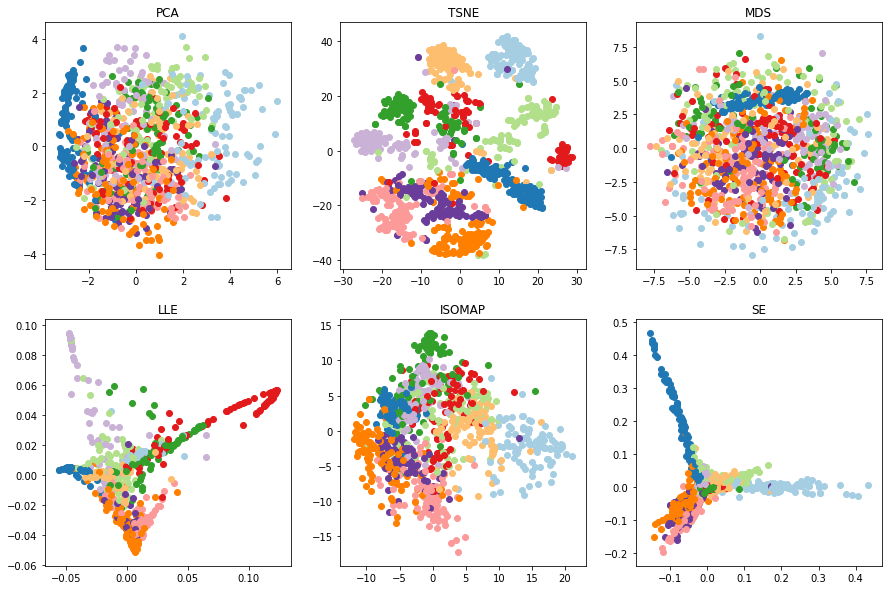

In [8]:
visualize_mnist(scat_feature1)

From the figure above, we could find that  the scattering network seem to perform well in extracting  and preserving those features in the MNIST dataset since there exist clusters in all these visualisation figures s, which means the key features of the data are well extracted and projected.

### Classification on the extracted features

Call our classification evaluation function. Outputs are cross entropy (negative log likelihood) and accuracy. The number before and after the '|' is the mean and the standard deviation respectively.

In [8]:
classification_mnist(scat_feature1, y_train, scat_feature2, y_test)

SVC: ce: 1.52501802048 | 0.134726171697, acc: 0.18 | 0.107703296143
LinearDiscriminantAnalysis: ce: 0.417484625077 | 1.11500235588, acc: 0.98 | 0.06
RandomForestClassifier: ce: 0.519676359259 | 0.133950668986, acc: 0.94 | 0.0916515138991
LogisticRegression: ce: 0.223123390989 | 0.120358834566, acc: 0.98 | 0.06


As we can see from the statistics, for the features extracted from MNIST by the Scattering Network, Logistic Regression still has the lowest cross entropy loss and the highest accuracy, which indicates the best classification performance. Linear Discriminant Analysis also has similat level of performance while non-linear classifier like SVM and Ranfom Forest performed suboptimally, we can see that a linear decision boundary is already sufficient for MNIST features. When taking standard deviation into consideration, 3 out of 4 has low std, indicating its highly linearity, which is consistent with the visualization.

## VGG19

Build VGG19 and extract the last-layer features for both the training set and the test set.

In [22]:
model = VGG19(weights='imagenet', include_top=False)
vgg19_feature_train = model.predict(x_train)
vgg19_feature_test = model.predict(x_test)

### Visulization of VGG19 Network

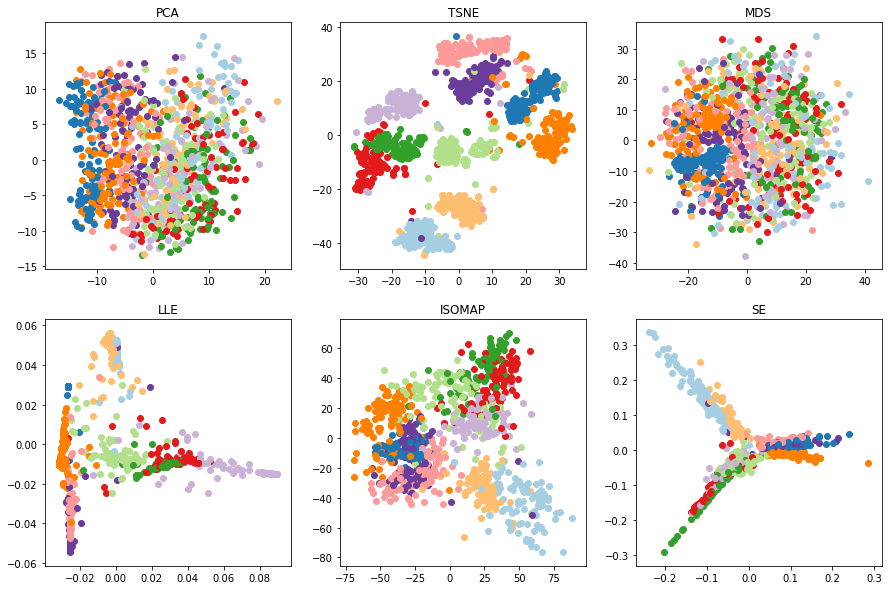

In [8]:
visualize_mnist(vgg19_feature_train)

VGG seems to perform better than Scattering Network from the visualisation aspect. The clusters are obvious and the cluster mixture seems to appear less than that of the Scattering Network. The t-SNE, SE and ISOMAP visualisations quite clearly indicate the ability in non-linear structure extraction of the VGG19 model.

### Classification on the extracted features

Call our classification evaluation function. Outputs are cross entropy (negative log likelihood) and accuracy. The number before and after the '|' is the mean and the standard deviation respectively.

In [24]:
classification_mnist(vgg19_feature_train, y_train, vgg19_feature_test, y_test)

SVC: ce: 0.805665570568 | 0.218437973267, acc: 0.54 | 0.22
LinearDiscriminantAnalysis: ce: 13.7808244169 | 8.53223598554, acc: 0.244444444444 | 0.226623089493
RandomForestClassifier: ce: 0.584524227972 | 0.175466817887, acc: 0.94 | 0.0916515138991
LogisticRegression: ce: 0.075207969605 | 0.110081354029, acc: 0.98 | 0.06


As we can see from the statistics, for the features extracted from MNIST by VGG 19, Logistic Regression still has the lowest cross entropy loss and the highest accuracy, which indicates the best classification performance. Random Forest also has similat level of performance while other classifier like SVM and Ranfom Forest performed suboptimally. We can see that the feature from VGG-19 is of high semantic meaning. When taking standard deviation into consideration, 2 out of 4 has low std, indicating its not quite stable, which is consistent with the visualization.

## ResNet50
Build ResNet50 and extract the last-layer features for both the training set and the test set.

In [23]:
model2 = ResNet50(weights='imagenet', include_top=False)
resnet_feature_train = model2.predict(x_train)
resnet_feature_test = model2.predict(x_test)

### Visulization of ResNet50 Network

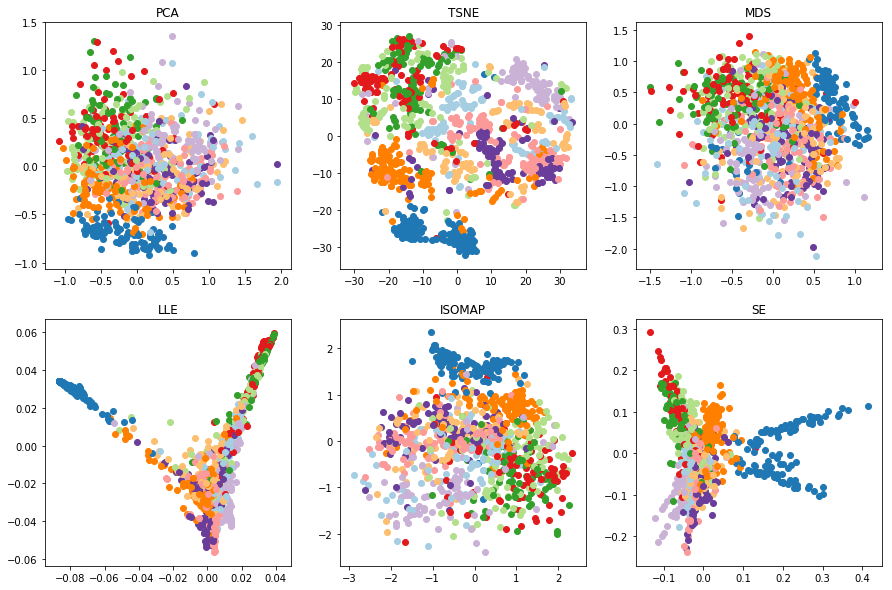

In [16]:
visualize_mnist(resnet_feature_train)

ResNet50 seems to perform worse than other two models in MNIST's dataset. Although the visualizations clearly project the extracted features, we could see that the ResNet50 seem to mix some features and cannot distinguish certain features with other features.

### Classification on the extracted features

Call our classification evaluation function. Outputs are cross entropy (negative log likelihood) and accuracy. The number before and after the '|' is the mean and the standard deviation respectively.

In [11]:
classification_mnist(resnet_feature_train, y_train, resnet_feature_test, y_test)

SVC: ce: 1.62142374547 | 0.107362974968, acc: 0.18 | 0.107703296143
LinearDiscriminantAnalysis: ce: 7.56229853181 | 6.9493266934, acc: 0.76 | 0.215406592285
RandomForestClassifier: ce: 0.760802879416 | 0.315333514733, acc: 0.86 | 0.128062484749
LogisticRegression: ce: 1.03198858952 | 0.224656799192, acc: 0.8 | 0.126491106407


As we can see from the statistics, for the features extracted from MNIST by ResNet 50, Random Forest has the lowest cross entropy loss and the highest accuracy, which indicates the best classification performance. Logistic Regression also has similat level of performance while other classifier like SVM and Ranfom Forest performed suboptimally. We can see that the feature from VGG-19 is of relatively low semantic meaning, resulting in lower accuracy. It is possibly due to the deep network structure where most information are thrown away. When taking standard deviation into consideration, most of them are quite high, indicating its not quite stable, which is consistent with the visualization.

## Visualization Summary - MNIST
For the MNIST's dataset, we used three networks to train and predict the extracted features and six approaches to visualise the extracted features. We want to analyse the visualisation via two aspects.

1. Deep Learning Networks Comparison through the Same Visualisation

    From the visualizations, we could see that Scattering Network and VGG19 seem to perform better than ResNet50. The features extracted by Scattering Network and VGG19 and dimensionally reduced by these visualisation approaches are presented better than those of ResNet50. It implies that Scattering Network and VGG19 are better in extracting and preserving the features in the MNIST dataset.

2. Different Visualisation Approaches through the Same Network

    From the visualisation figures above, non-linear structure in the data is very significant since PCA which tries to find the linear transformation among dimensions and MDS which measures the distance similarity between objects seem to mix clusters, which means some features may  be very similar even though they are from different individuals in the dataset.

    Since t-SNE is particularly sensitive to local structure, while ISOMAP, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clusters local groups of samples. Therefore, we could clearly see a separate cluster for every digit and it shows that t-SNE is a superior way to visualise, reduce dimensionality for samples which exhibit manifold structure. 


## Classification Summary - MNIST
We summarize the classification results in the following table: (CE stands for cross entropy and Acc stands for accuracy)

|  | SVM   |  LDA  |  RandomForest  |  Logistic Regression |
|----------------|-----------------|---------------|----------------|------------|
| ScatNet (CE)  | 1.53 $\pm$ 0.13 | 0.42 $\pm$ 1.12 | 0.52 $\pm$ 0.13  | 0.22 $\pm$ 0.12 |
| ScatNet (Acc)  | 0.18 $\pm$ 0.11 | 0.98 $\pm$ 0.06 | 0.94 $\pm$ 0.09 | 0.98 $\pm$ 0.06 |
| VGG19 (CE)    | 0.81 $\pm$ 0.22 | 13.78 $\pm$ 8.53 | 0.58 $\pm$ 0.18 | 0.08 $\pm$ 0.11 |
| VGG19 (Acc)   | 0.54 $\pm$ 0.22 | 0.24 $\pm$ 0.23 | 0.94 $\pm$ 0.09 | 0.98 $\pm$ 0.06 |
| ResNet50 (CE)  | 1.62 $\pm$ 0.11 | 7.56 $\pm$ 6.95 | 0.76 $\pm$ 0.32 | 1.03 $\pm$ 0.22 |
| ResNet50 (Acc) | 0.18 $\pm$ 0.11 | 0.76 $\pm$ 0.22 | 0.86 $\pm$ 0.13 | 0.8 $\pm$ 0.13 |

As shown in the table, the Logistic Regression and Random Forest are the best among all results. Especially when compared with the large gap between different features shown by the remaining two methods, we may conclude that Logistic Regression and Random Forest are less likely to be influenced by the different (quality of the) features. Another observation is the smaller standard deviation (i.e. variance) compared with the Rapheal's Drawing dataset. This is understandable because the dataset has much larger size, enabling the models to better capture the data distributions. Furthermore, by analyzing performance gaps of certain algorithms, we may learn some characteristics about our learned feature distributions. For example, the low accuracy of LDA on VGG19 features may indicate the VGG19 is not combination of gaussion distribution with equal variance. 

We may further analyze the three types of features on a more general level. Features extracted by deep nets may be too complicated (and not necessary) for such simple tasks. This may be more obvious when we compare ResNet50 with VGG19, since the former one shows inferior results. Also, to feed the correct size into such deep networks, we need to resize the images to much larger sizes, which may degrade the image quality.

### References
1. <cite>Oyallon, E., Belilovsky, E., & Zagoruyko, S. (2017, October). Scaling the scattering transform: Deep hybrid networks. In International Conference on Computer Vision (ICCV).</cite>
2. <cite>Liu, H., Chan, R. H., & Yao, Y. (2016). Geometric tight frame based stylometry for art authentication of van Gogh paintings. Applied And Computational Harmonic Analysis, 41(2), 590-602.</cite>
3. <cite>Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.</cite>
4. <cite>He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).</cite>
5. <cite>Deng, J., Dong, W., Socher, R., Li, L. J., Li, K., & Fei-Fei, L. (2009, June). Imagenet: A large-scale hierarchical image database. In Computer Vision and Pattern Recognition, 2009. CVPR 2009. IEEE Conference on (pp. 248-255). IEEE.</cite>